This script generates hillslope with the following parameters:
#### Step 1 - The surface with 20° slope
##### Length of the catchment = 1000 m, slope = 20°, dx_surface = 10 m, dz_surface =  2 m? or defined later in step 2?
#### Step 2 - The vertical cross-section [along a single column]
#### Step 3:Allocate 2D matrix with unique IDs based on the layer
#### For organic layer - 1001, mineral layer = 1002, bedrock = 1003 

##### Note that the maximum depth of the layers is considered for allocating the IDs 

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats'))
#sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats_new'))
import meshing_ats
#import meshing_ats_new

import meshing_ats_2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import importlib
importlib.reload(meshing_ats)
importlib.reload(meshing_ats_2)

<module 'meshing_ats_2' from '/home/rk/ats_rk/amanzi/src/physics/ats/tools/meshing_ats_rk/meshing_ats_2.py'>

### Defining the geometry and meshing for the Yakou catchement

#### Step 1 - The surface with 20° slope
##### Length of the catchment = 1000 m, slope = 20°, dx_surface = 10 m, dz_surface =  2 m? or defined later in step 2?

# of x and z elements:  101 ,  101
# of cells:  100


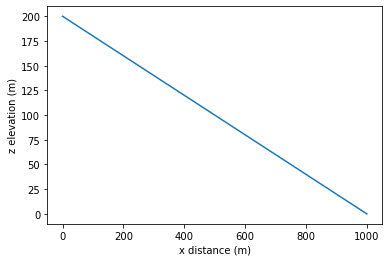

In [4]:
# 1 km long hillslope, 20% slope
x = np.linspace(0,1000,101)
z = 200 - 0.2*x 
# Gradient = 200/1000 = 0.2
print ('# of x and z elements: ',len(x),', ',len(z))
plt.plot(x,z)
plt.xlabel('x distance (m)')
plt.ylabel('z elevation (m)')
m2 = meshing_ats_2.Mesh2D.from_Transect(x,z) # Creates a recatangular mesh with x + z nodes, x - 1 number of cells
print ('# of cells: ', m2.num_cells())

#### Step 2 - The vertical cross-section [along a single column]

In [5]:
### To define the vertical properties of the Yakou catchment (Assumptions)


layer_types_yakou = [] # Assuming 'constant' for each layers, i.e. dz within the layer is constant -
                       # Q - What other options are available?

layer_data_yakou = [] # this data depends upon the layer type, but
                # for constant is the thickness of the layer

layer_ncells_yakou = [] # number of cells (in the vertical) in the layer.
                        # The dz of each cell is the layer thickness / number of cells. - Why is it required?

layer_mat_ids_yakou = [] # The material ID.  This may be either a constant int (for
                   # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.

layer_depth_yakou = []  # used later to get the mat ids right, just for bookkeeping

# We are considering 3 layers - Organic layer, Mineral layer, Bedrock
# Requirement to find the depth of the individual layers - 
# Research articles! (Conduct ERT/IP experiments and geological experiments)
### Assuming the lower depth of each layers:

depth_org_layer = 0.60 # m
depth_mineral_layer = 30 # m
depth_bedrock = 40 # m
        
# Starting length of each vertical cell, dz = 0.01
# We will also telescope the mesh, starting at 0.01 m grid cell and growing it larger in each layer.
# The dz values vary as such, For the organic layer - 1.2, mineral layer - 1.4, Bedrock - 1.5 
# Can change the values later and check if the results are affected

dz = 0.01
i = 0
current_depth = 0

while current_depth <= depth_bedrock:
    if (current_depth >= 0) & (current_depth <= depth_org_layer):     # organic
        dz *= 1.2 
    elif (current_depth > depth_org_layer) & (current_depth <= depth_mineral_layer): # mineral
        dz *= 1.4
    elif (current_depth > depth_mineral_layer) & (current_depth < depth_bedrock): # bedrock
        dz *= 1.5
    layer_types_yakou.append("constant")
    layer_data_yakou.append(dz) # Thickness of all the dz's will be added in the numpy array 
    layer_ncells_yakou.append(1) # Why append only 1? - Is'nt it the dz value?
    current_depth += dz
    layer_depth_yakou.append(current_depth)
    i += 1

# Removing the last element from the lists as it exceeds 40 m
layer_types_yakou.pop()
layer_data_yakou.pop()
#layer_ncells_yakou.pop()
layer_depth_yakou.pop()

# now add in a bunch of cells to reach 40 m
num_of_layers=len(layer_data_yakou)
layer_types_yakou.append('constant')
layer_data_yakou.append(depth_bedrock - sum(layer_data_yakou))  # note sum(layer_data) == the total mesh thickness at this point
#layer_ncells_yakou.append(int(np.floor(layer_data_yakou[-2]/dz)))
#layer_ncells_yakou.append(1)
layer_depth_yakou.append(depth_bedrock)

# Note that the boundaries between the layers are not clearly defined

In [6]:
print(len(layer_ncells_yakou))

28


In [7]:
print(layer_depth_yakou)

[0.012, 0.0264, 0.04368, 0.064416, 0.0892992, 0.11915904, 0.154990848, 0.19798901759999998, 0.24958682111999997, 0.31150418534399993, 0.3858050224127999, 0.4749660268953599, 0.5819592322744318, 0.7103510787293181, 0.890099663766159, 1.1417476828177362, 1.4940549094899442, 1.9872850268310356, 2.6778071911085632, 3.6445382210971022, 4.997961663081057, 6.892754481858592, 9.545464428147142, 13.259258352951111, 18.458569847676667, 25.737605940292447, 35.92825646995453, 40]


In [8]:
### Another idea for layering:
# Consider constant cell size

Text(0.5, 0, 'Cell number')

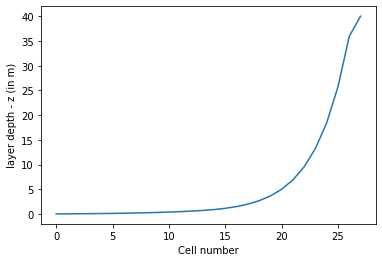

In [9]:
plt.plot(layer_depth_yakou)
plt.ylabel('layer depth - z (in m)')
plt.xlabel('Cell number')

#### Step 3:Allocate 2D matrix with unique IDs based on the layer
#### For organic layer - 1001, mineral layer = 1002, bedrock = 1003 

##### Note that the maximum depth of the layers is considered for allocating the IDs 

In [10]:
print(layer_depth_yakou)

[0.012, 0.0264, 0.04368, 0.064416, 0.0892992, 0.11915904, 0.154990848, 0.19798901759999998, 0.24958682111999997, 0.31150418534399993, 0.3858050224127999, 0.4749660268953599, 0.5819592322744318, 0.7103510787293181, 0.890099663766159, 1.1417476828177362, 1.4940549094899442, 1.9872850268310356, 2.6778071911085632, 3.6445382210971022, 4.997961663081057, 6.892754481858592, 9.545464428147142, 13.259258352951111, 18.458569847676667, 25.737605940292447, 35.92825646995453, 40]


In [11]:
print(len(layer_depth_yakou))

28


In [12]:
m2.num_cells()

100

In [13]:
depth_org_layer, depth_mineral_layer, depth_bedrock

(0.6, 30, 40)

In [14]:
layer_depth_yakou[0] 

0.012

In [15]:
mat_ids = np.zeros((m2.num_cells(), len(layer_depth_yakou)), 'i') # Creating a numpy array with zeros (int value)
for i in range(m2.num_cells()):
    for j in range(len(layer_depth_yakou)): # len(layer_depth_yakou) - Number of cells in the vertical depth
        if (layer_depth_yakou[j] < depth_org_layer):
            mat_ids[i,j] = 1001 # Organic layer
        elif ((layer_depth_yakou[j] >= depth_org_layer) & (layer_depth_yakou[j] < depth_mineral_layer)):
            mat_ids[i,j] = 1002 # Mineral layer
        else:
            mat_ids[i,j] = 1003 # Bedrock
            

In [16]:
m2.num_cells()

100

In [17]:
np.shape(mat_ids[:,25])

(100,)

In [18]:
# filling out layer_mat_ids
layers = []
for j in range(len(layer_depth_yakou)):
    layers.append(mat_ids[:,j])
#for j in range(len(layer_depth_yakou),sum(layer_ncells)):
    #layer_mat_ids.append(101*np.ones((100,),'i'))

#print('# of rows, # of cells:', np.shape(layer_mat_ids))

In [19]:
# filling out layer_mat_ids
layer_mat_ids_yakou = []
for j in range(len(layer_depth_yakou)):
    layer_mat_ids_yakou.append(mat_ids[:,j])
# Q - Why is the next 2 lines of code written?
for j in range(len(layer_depth_yakou),sum(layer_ncells_yakou)):
    layer_mat_ids_yakou.append(101*np.ones((100,),'i'))

print('# of rows, # of cells:', np.shape(layer_mat_ids_yakou))

# of rows, # of cells: (28, 100)


In [20]:
print(layer_mat_ids_yakou)

[array([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001], dtype=int32), array([1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
       1001, 1001, 100

In [21]:
np.shape(mat_ids)

(100, 28)

In [22]:
import importlib
importlib.reload(meshing_ats)
importlib.reload(meshing_ats_2)

<module 'meshing_ats_2' from '/home/rk/ats_rk/amanzi/src/physics/ats/tools/meshing_ats_rk/meshing_ats_2.py'>

In [ ]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types_yakou,layer_data_yakou, layer_ncells_yakou, layer_mat_ids_yakou)
m3.write_exodus("Yakou_model.exo")

To deal with error: 'TypeError: sorted expected 1 argument, got 2'
- https://stackoverflow.com/questions/57429471/equivalent-of-sorted-function-with-compare-function-in-python-3 - Correct!
- https://docs.python.org/3/howto/sorting.html

To deal with this error - AttributeError: type object 'int' has no attribute '__cmp__'
- https://stackoverflow.com/questions/36921558/how-int-object-uses-operator-without-eq-method-in-python2

In [ ]:
# make the mesh, save it as an exodus file
m3 = meshing_ats_2.Mesh3D.extruded_Mesh2D(m2, layer_types_yakou,layer_data_yakou, layer_ncells_yakou, layer_mat_ids_yakou)
m3.write_exodus("Yakou_model.exo")

In [104]:
# How sorting works
student_tuples = [
    ('john', 'A', 15),
    ('jane', 'B', 12),
    ('dave', 'B', 10),
]
student_tuples

[('john', 'A', 15), ('jane', 'B', 12), ('dave', 'B', 10)]

In [105]:
sorted(student_tuples, key=lambda student: student[0])   # sort by age

[('dave', 'B', 10), ('jane', 'B', 12), ('john', 'A', 15)]

In [ ]:
importlib.reload(meshing_ats_2)
import yakou_model